In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

IMG_WIDTH, IMG_HEIGHT = 224, 224

import tensorflow_hub as hub
from tensorflow.keras.applications.densenet import (
    DenseNet121,
    preprocess_input,
)
import pandas as pd
import numpy as np
import os
import IPython.display as display
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import (
    Dense,
    GlobalAveragePooling2D,
    Conv2D,
    Flatten,
    GlobalMaxPooling2D,
    Dropout,
)

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam
from datetime import datetime
from packaging import version
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import (
    TensorBoard,
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
)
import efficientnet.tfkeras as enet


gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(
            len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs",
        )
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


def append_extension(fn):
    return (fn + ".jpg").zfill(7)


def ordered_logit(class_number):
    # zero portability
    target = np.zeros(4, dtype=int)
    target[: class_number - 2] = 1
    return target


DATADIR = r"./adult"
CSV_PATH = r"./adult/CastControls_ALP.xlsx"
response = pd.read_excel(CSV_PATH, sheet_name=0,)[["GreenID", "Grade"]].dropna(
    axis=0, subset=["Grade"]
)
response.Grade = response.Grade.astype("int")
response.GreenID = response.GreenID.astype("str").apply(append_extension)
response = response[response.Grade != 99]
response = pd.concat(
    [response, pd.DataFrame.from_dict(dict(response.Grade.apply(ordered_logit))).T,],
    axis=1,
)


# shuffle dataset
response = response.sample(frac=1)
seed = np.random.randint(30027)


def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))


def soft_acc_multi_output(y_true, y_pred):
    return K.mean(
        K.all(
            K.equal(
                K.cast(K.round(y_true), "int32"), K.cast(K.round(y_pred), "int32"),
            ),
            axis=1,
        )
    )

from tensorflow.keras import mixed_precision

policy = tf.keras.mixed_precision.experimental.Policy("mixed_float16")
mixed_precision.experimental.set_policy(policy)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
train_gen = ImageDataGenerator(
    rotation_range=5,
    fill_mode="reflect",
    horizontal_flip=True,
    #     vertical_flip=True,
    validation_split=0.1,
    # dude i wasnt cheating...
    rescale=1.0 / 255.0,
    #     preprocessing_function = preprocess_input
    zoom_range=0.1,
)

valid_gen = ImageDataGenerator(validation_split=0.1, rescale=1.0 / 255.0,)

train_set = train_gen.flow_from_dataframe(
    dataframe=response,
    directory=DATADIR,
    x_col="GreenID",
    target_size=(224, 224),
    color_mode="rgb",
    subset="training",
    shuffle=True,
    #     class_mode = "sparse"
    #     y_col="Grade",
    y_col=[0, 1, 2, 3,],
    class_mode="raw",
)

validation_set = valid_gen.flow_from_dataframe(
    dataframe=response,
    directory=DATADIR,
    x_col="GreenID",
    target_size=(224, 224),
    color_mode="rgb",
    subset="validation",
    shuffle=True,
    batch_size=28,
    #     class_mode = "sparse"
    #     y_col="Grade",
    y_col=[0, 1, 2, 3,],
    class_mode="raw",
)

train_set.reset()
validation_set.reset()
# print(next(validation_set)[1].shape)

In [ ]:
conv_base = enet.EfficientNetB0(
    include_top=False, input_shape=(224, 224, 3), pooling="avg", weights="imagenet",
)
conv_base.trainable = False

x = conv_base.output
x = Dropout(0.5)(x)
preds = Dense(4, activation="sigmoid")(x)
model = Model(inputs=conv_base.input, outputs=preds)

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=[soft_acc_multi_output],
)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=21, restore_best_weights=True,
)
reduce_lr_plateau = ReduceLROnPlateau(monitor="val_loss", patience=7, factor=0.8)

history_1 = model.fit_generator(
    generator=train_set,
    epochs=25,
    validation_data=validation_set,
    callbacks=[early_stopping, reduce_lr_plateau],
    #     verbose=0,
)

# model.save(
#     filepath="./saved_models/my_effnet/my_effnet_untuned_1_layer.h5", save_format="h5",
# )

In [ ]:
#########################
## fine tuning
#########################


fine_tune = [layer.name for layer in model.layers].index(r"top_conv")

model.trainable = True
for layer in model.layers[:fine_tune]:
    layer.trainable = False
for layer in model.layers[fine_tune:]:
    layer.trainable = True

print(
    f"from {fine_tune} of {len(model.layers)} layers; {len(model.trainable_variables)} trainables variables"
)
model.compile(
    optimizer=keras.optimizers.Nadam(),
    loss="binary_crossentropy",
    metrics=[soft_acc_multi_output],
)
train_set.reset()
validation_set.reset()


# logdir_name = (
#     r".\tfb\logs\effnet\\"
#     + "effnet__1_layer"
#     + "__"
#     + datetime.now().strftime("%Y%m%d-%H%M%S")
# )
# tensorboard_callback = TensorBoard(log_dir=logdir_name)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=21, restore_best_weights=True,
)
reduce_lr_plateau = ReduceLROnPlateau(monitor="val_loss", patience=7, factor=0.8)

# initial epoch is useless for keras optimizers as they update internally independent of epoch number
history_fine = model.fit_generator(
    generator=train_set,
    epochs=100,
    validation_data=validation_set,
    callbacks=[early_stopping, reduce_lr_plateau,],
)

# model.save(
#     filepath="./saved_models/my_effnet/tuned_1_layer.h5", save_format="h5",
# )
# model.save_weights(
#     "./saved_models/my_effnet/tuned_1_layer_weights_only.h5", save_format="h5",
# )

In [ ]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []

# model__ = tf.keras.models.load_model(
#     "./saved_models/my_effnet/tuned_1_layer.h5",
#     custom_objects={"soft_acc_multi_output": soft_acc_multi_output},
# )

# model__.trainable = False
# len(model__.trainable_variables)
# model__.compile(
#         optimizer=keras.optimizers.Nadam(learning_rate=0.0001),
#         loss="binary_crossentropy",
#         metrics=[soft_acc_multi_output],
#     )

model__ = generate_base_model()

In [ ]:
traintest = list(kf.split(np.zeros(len(response)), response["Grade"]))
train_index, test_index = np.stack(traintest)[:, 0][0], np.stack(traintest)[:, 1][0]


train_gen = ImageDataGenerator(
    rotation_range=5,
    fill_mode="reflect",
    horizontal_flip=True,
    validation_split=0,
    rescale=1.0 / 255.0,
    zoom_range=0.1,
)
valid_gen = ImageDataGenerator(validation_split=0.5, rescale=1.0 / 255.0,)

train_set = train_gen.flow_from_dataframe(
    dataframe=response.iloc[train_index],
    directory=DATADIR,
    x_col="GreenID",
    target_size=(224, 224),
    color_mode="rgb",
    subset="training",
    shuffle=False,
    y_col=[0, 1, 2, 3,],
    class_mode="raw",
)

validation_set = valid_gen.flow_from_dataframe(
    dataframe=response.iloc[test_index],
    directory=DATADIR,
    x_col="GreenID",
    target_size=(224, 224),
    color_mode="rgb",
    subset="training",
    shuffle=True,
    batch_size=64,
    y_col=[0, 1, 2, 3,],
    class_mode="raw",
)

test_set = valid_gen.flow_from_dataframe(
    dataframe=response.iloc[test_index],
    directory=DATADIR,
    x_col="GreenID",
    target_size=(224, 224),
    color_mode="rgb",
    subset="validation",
    shuffle=True,
    batch_size=64,
    y_col=[0, 1, 2, 3,],
    class_mode="raw",
)

In [ ]:
model__ = fine_tune_model(model__,)

In [ ]:
# batch = next(test_set)
# true_labels = batch[1]
# predictions = model__.predict(batch[0])

# print(model__.metrics_names)
# print(
#     model__.evaluate(train_set, verbose=0)
# )  # working well with original unstratified model, including both trainning and testing sets?

model__.fit(
    x=train_set,
    epochs=10,
    validation_data=validation_set,
    callbacks=[early_stopping, reduce_lr_plateau],
    #         verbose=0,
)

In [3]:
def generate_train_val_test(train_index, val_index, test_index):
    train_dataset = response.iloc[train_index]
    val_dataset = response.iloc[val_index]
    test_dataset = response.iloc[test_index]
    train_gen = ImageDataGenerator(
        rotation_range=5,
        fill_mode="reflect",
        horizontal_flip=True,
        rescale=1.0 / 255.0,
        zoom_range=0.1,
    )
    valid_test_gen = ImageDataGenerator(rescale=1.0 / 255.0,)

    train_set = train_gen.flow_from_dataframe(
        dataframe=train_dataset,
        directory=DATADIR,
        x_col="GreenID",
        target_size=(224, 224),
        color_mode="rgb",
        subset="training",
        shuffle=True,
        y_col=[0, 1, 2, 3,],
        class_mode="raw",
    )

    validation_set = valid_test_gen.flow_from_dataframe(
        dataframe=val_dataset,
        directory=DATADIR,
        x_col="GreenID",
        target_size=(224, 224),
        color_mode="rgb",
        subset="training",
        shuffle=False,
        batch_size=64,
        y_col=[0, 1, 2, 3,],
        class_mode="raw",
    )

    test_set = valid_test_gen.flow_from_dataframe(
        dataframe=test_dataset,
        directory=DATADIR,
        x_col="GreenID",
        target_size=(224, 224),
        color_mode="rgb",
        subset="training",
        shuffle=False,
        batch_size=64,
        y_col=[0, 1, 2, 3,],
        class_mode="raw",
    )
    return train_set, validation_set, test_set


from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
innerkf = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)
response = response.sample(frac=1.0)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=21, restore_best_weights=True,
)
reduce_lr_plateau = ReduceLROnPlateau(monitor="val_loss", patience=7, factor=0.8)


def generate_base_model():
    conv_base = enet.EfficientNetB0(
        include_top=False, input_shape=(224, 224, 3), pooling="avg", weights="imagenet",
    )
    conv_base.trainable = False

    x = conv_base.output
    x = Dropout(0.5)(x)
    preds = Dense(4, activation="sigmoid")(x)
    model = Model(inputs=conv_base.input, outputs=preds)

    model.compile(
        optimizer=keras.optimizers.Nadam(lr=0.0014),
        loss="binary_crossentropy",
        metrics=[soft_acc_multi_output],
    )

    return model


def fine_tune_model(model, fine_tune=None):
    if fine_tune is None:
        try:
            fine_tune = [layer.name for layer in model.layers].index(r"top_conv")
        except:
            pass

    model.trainable = True
    for layer in model.layers[:fine_tune]:
        layer.trainable = False
    for layer in model.layers[fine_tune:]:
        layer.trainable = True

    model.compile(
        optimizer=keras.optimizers.Nadam(lr=0.0003),
        loss="binary_crossentropy",
        metrics=[soft_acc_multi_output],
    )

    return model

In [5]:
import gc
def stratified_cv(fine_tune_layer=None):
    acc_coef_scores = []
    raw_outputs = []
    for train_index, val_test_index in kf.split(
        tf.keras.backend.clear_session()
        gc.collect()
        np.zeros(len(response)), response["Grade"]
    ):
        val_index, test_index = next(
            innerkf.split(
                np.zeros(len(val_test_index)), response["Grade"].iloc[val_test_index]
            )
        )
        val_index, test_index = val_test_index[val_index], val_test_index[test_index]
        train_set, validation_set, test_set = generate_train_val_test(
            train_index, val_index, test_index
        )
        model = generate_base_model()

        _ = model.fit(
            x=train_set,
            epochs=15,
            validation_data=validation_set,
            callbacks=[early_stopping, reduce_lr_plateau],
            verbose=0,
        )

        model = fine_tune_model(model, fine_tune=fine_tune_layer)

        _ = model.fit(
            x=train_set,
            epochs=100,
            validation_data=validation_set,
            callbacks=[early_stopping, reduce_lr_plateau],
            verbose=0,
        )

        batch = next(test_set)
        true_labels = batch[1]
        predictions = model.predict(batch[0])
        acc = soft_acc_multi_output(predictions, true_labels).numpy()
        corr = np.corrcoef(np.sum(predictions, axis=1), np.sum(true_labels, axis=1))[0][
            1
        ]
        acc_coef_scores.append([acc, corr])
        raw_outputs.append([np.array(response.iloc[test_index].index), true_labels, predictions])
        del train_set, validation_set, test_set, _, model, batch, true_labels, predictions, acc, corr
        tf.keras.backend.clear_session()
        gc.collect()
    return acc_coef_scores, raw_outputs

In [7]:
#  np.where(np.array(['conv' in layer.name for layer in model.layers]) == True)[0][::-1]
trainable_sequence = np.array([227, 225, 217, 214, 210, 202, 199, 195, 187, 184, 180, 172, 169,
       167, 159, 156, 152, 144, 141, 137, 129, 126, 124, 116, 113, 109,
       101,  98,  94,  86,  83,  81,  73,  70,  66,  58,  55,  53,  45,
        42,  38,  30,  27,  25,  17,  14,  12,   4,   1])


fine_tune_scores_acc_coef = []
fine_tune_raw_outputs = []

for fine_tune in trainable_sequence[12:20]:
    acc_coef_scores, raw_outputs = stratified_cv(fine_tune)
    fine_tune_scores_acc_coef.append(acc_coef_scores)
    fine_tune_raw_outputs.append(raw_outputs)
    np.save(r"./stratified_cross_validation_results/effnets/multinomial_acc_coef_12-20", np.array(fine_tune_scores_acc_coef))
    np.save(r"./stratified_cross_validation_results/effnets/multinomial_raw_outputs_12-20", np.array(fine_tune_raw_outputs))
    del acc_coef_scores, raw_outputs
    tf.keras.backend.clear_session()
    gc.collect()


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 6 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 449 validated image filenames.
Found 57 validated image filenames.
Found 57 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 3 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 2 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 452 validated image filenames.
Found 56 validated image filenames.
Found 55 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 6 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 449 validated image filenames.
Found 57 validated image filenames.
Found 57 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 5 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 450 validated image filenames.
Found 56 validated image filenames.
Found 57 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 4 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 2 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 452 validated image filenames.
Found 54 validated image filenames.
Found 57 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 6 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 449 validated image filenames.
Found 57 validated image filenames.
Found 57 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 3 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 2 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 452 validated image filenames.
Found 56 validated image filenames.
Found 55 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 6 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 449 validated image filenames.
Found 57 validated image filenames.
Found 57 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 5 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 450 validated image filenames.
Found 56 validated image filenames.
Found 57 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 4 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 2 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 452 validated image filenames.
Found 54 validated image filenames.
Found 57 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 6 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 449 validated image filenames.
Found 57 validated image filenames.
Found 57 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 3 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 2 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 452 validated image filenames.
Found 56 validated image filenames.
Found 55 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 6 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 449 validated image filenames.
Found 57 validated image filenames.
Found 57 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 5 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 450 validated image filenames.
Found 56 validated image filenames.
Found 57 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 4 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 2 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 452 validated image filenames.
Found 54 validated image filenames.
Found 57 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 6 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 449 validated image filenames.
Found 57 validated image filenames.
Found 57 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 3 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 2 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 452 validated image filenames.
Found 56 validated image filenames.
Found 55 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 6 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 449 validated image filenames.
Found 57 validated image filenames.
Found 57 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 5 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 450 validated image filenames.
Found 56 validated image filenames.
Found 57 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 4 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 2 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 452 validated image filenames.
Found 54 validated image filenames.
Found 57 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 6 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 449 validated image filenames.
Found 57 validated image filenames.
Found 57 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 3 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 2 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 452 validated image filenames.
Found 56 validated image filenames.
Found 55 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 6 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 449 validated image filenames.
Found 57 validated image filenames.
Found 57 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 5 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 450 validated image filenames.
Found 56 validated image filenames.
Found 57 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 4 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 2 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 452 validated image filenames.
Found 54 validated image filenames.
Found 57 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 6 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 449 validated image filenames.
Found 57 validated image filenames.
Found 57 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 3 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 2 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 452 validated image filenames.
Found 56 validated image filenames.
Found 55 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 6 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 449 validated image filenames.
Found 57 validated image filenames.
Found 57 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 5 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 450 validated image filenames.
Found 56 validated image filenames.
Found 57 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 4 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 2 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 452 validated image filenames.
Found 54 validated image filenames.
Found 57 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 6 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 449 validated image filenames.
Found 57 validated image filenames.
Found 57 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 3 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 2 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 452 validated image filenames.
Found 56 validated image filenames.
Found 55 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 6 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 449 validated image filenames.
Found 57 validated image filenames.
Found 57 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 5 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 450 validated image filenames.
Found 56 validated image filenames.
Found 57 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 4 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 2 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 452 validated image filenames.
Found 54 validated image filenames.
Found 57 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 6 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 449 validated image filenames.
Found 57 validated image filenames.
Found 57 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 3 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 2 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 452 validated image filenames.
Found 56 validated image filenames.
Found 55 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 6 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 449 validated image filenames.
Found 57 validated image filenames.
Found 57 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 5 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 450 validated image filenames.
Found 56 validated image filenames.
Found 57 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 4 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 2 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 452 validated image filenames.
Found 54 validated image filenames.
Found 57 validated image filenames.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


In [ ]:
# maybe also include an untuned version for comparison?
# np.array([list(response.iloc[np.stack(np.array(raw_outputs)[0,:,0])[i]].index) for i in range(5)])

8
[[31  9  4  1  0]
 [10 29 11  5  0]
 [ 7 18 41 10  3]
 [ 0  8 13 15 13]
 [ 0  0 11 12 32]]
+++++++++++++++++++++++++++++++++
+++++++++++++++++++++++++++++++++
[[0.68888889 0.2        0.08888889 0.02222222 0.        ]
 [0.18181818 0.52727273 0.2        0.09090909 0.        ]
 [0.08860759 0.2278481  0.51898734 0.12658228 0.03797468]
 [0.         0.16326531 0.26530612 0.30612245 0.26530612]
 [0.         0.         0.2        0.21818182 0.58181818]]
+++++++++++++++++++++++++++++++++
+++++++++++++++++++++++++++++++++
0.5229681978798587
+++++++++++++++++++++++++++++++++
+++++++++++++++++++++++++++++++++
max accuracy with tuning from 225 layers, or tune 8 layers


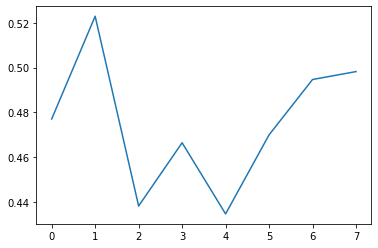

In [8]:
import numpy as np

acc_coef = np.load(r"./stratified_cross_validation_results/effnets/multinomial_acc_coef_12-20.npy", allow_pickle=True)
raw_outputs = np.load(r"./stratified_cross_validation_results/effnets/multinomial_raw_outputs_12-20.npy", allow_pickle=True)
print(len(acc_coef))


from sklearn.metrics import confusion_matrix


def show_confusion_matrix(raw_outputs, fine_tune_layers):

    y_true = np.sum(np.vstack(raw_outputs[fine_tune_layers, :, 1]), axis=1)
    y_pred = np.sum(
        np.rint(np.vstack(raw_outputs[fine_tune_layers, :, 2])), axis=1
    ).astype(int)
    return confusion_matrix(y_true, y_pred)

def show_matrix_percentage(confusion_matrix):
    return np.transpose(np.transpose(my_confusion_matrix) / np.sum(my_confusion_matrix, axis=1))

# total accuracy
def calculate_accuracy(my_confusion_matrix):
    return np.trace(my_confusion_matrix)/np.sum(my_confusion_matrix)

max_acc_layer = np.argmax([calculate_accuracy(show_confusion_matrix(raw_outputs, i))  for i in range(len(acc_coef))])

my_confusion_matrix = show_confusion_matrix(raw_outputs,max_acc_layer)
print(my_confusion_matrix)
print("+++++++++++++++++++++++++++++++++")
print("+++++++++++++++++++++++++++++++++")
print(show_matrix_percentage(my_confusion_matrix))
print("+++++++++++++++++++++++++++++++++")
print("+++++++++++++++++++++++++++++++++")
print(calculate_accuracy(my_confusion_matrix))

import matplotlib.pyplot as plt
plt.plot([i for i in range(len(acc_coef))],[calculate_accuracy(show_confusion_matrix(raw_outputs, i))  for i in range(len(acc_coef))])
print("+++++++++++++++++++++++++++++++++")
print("+++++++++++++++++++++++++++++++++")

trainable_sequence = np.array([227, 225, 217, 214, 210, 202, 199, 195, 187, 184, 180, 172, 169,
       167, 159, 156, 152, 144, 141, 137, 129, 126, 124, 116, 113, 109,
       101,  98,  94,  86,  83,  81,  73,  70,  66,  58,  55,  53,  45,
        42,  38,  30,  27,  25,  17,  14,  12,   4,   1])
print(f"max accuracy with tuning from {trainable_sequence[max_acc_layer]} layers, or tune {233-trainable_sequence[max_acc_layer]} layers")

In [ ]:
np.array(cvscores)[:, 1][:, 0][4].shape

In [ ]:
np.array(cvscores)[:, 0]

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(
    y_true=K.sum(K.cast(K.round(cvscores[1][1][0]), "int32"), axis=1).numpy(),
    y_pred=K.sum(K.cast(K.round(cvscores[1][1][1]), "int32"), axis=1).numpy(),
)

In [ ]:
mycsv = pd.DataFrame(
    np.hstack(
        np.array(
            [
                np.vstack(np.array(cvscores)[:, 1][:, 0]),
                np.vstack(np.array(cvscores)[:, 1][:, 1]),
            ]
        )
    )
)

In [ ]:
np.allclose(mycsv[range(4, 8)].to_numpy(), np.vstack(np.array(cvscores)[:, 1][:, 1]))

In [ ]:
mycsv.to_csv(
    "./stratified_cross_validation_results/effnet_multinomial.csv", index=False
)
# next time include which image?

In [ ]:
mycsv = pd.read_csv("./stratified_cross_validation_results/effnet_multinomial.csv")
y_true = np.sum((mycsv[[str(i) for i in range(0, 4)]]).to_numpy(dtype=int), axis=1)
y_pred = np.sum(
    np.rint((mycsv[[str(i) for i in range(4, 8)]]).to_numpy()), axis=1
).astype(int)

In [ ]:
from sklearn.metrics import confusion_matrix
my_confusion_matrix = confusion_matrix(y_true, y_pred,)
my_confusion_matrix

In [ ]:
np.transpose(np.transpose(my_confusion_matrix) / np.sum(my_confusion_matrix, axis=1))

In [ ]:
# coef
np.corrcoef(y_true, np.sum((mycsv[[str(i) for i in range(4, 8)]]).to_numpy(), axis=1))

In [ ]:
# acc
sum(np.isclose(y_true, y_pred)) / len(y_pred)

In [ ]:
# from tensorflow.keras.utils import plot_model

# plot_model(model, to_file="effnet.png", show_shapes=True)
# from IPython.display import Image

# Image(filename="effnet.png")

In [ ]:
response = response.sample(frac=1.0)

test_set = valid_gen.flow_from_dataframe(
    dataframe=response,
    directory=DATADIR,
    x_col="GreenID",
    target_size=(224, 224),
    color_mode="rgb",
    subset="validation",
    shuffle=False,
    batch_size=56,
    y_col=[0, 1, 2, 3,],
    class_mode="raw",
    #     seed = seed
)

batch = next(test_set)
true_labels = batch[1]
predictions = model.predict(batch[0])

print(model.metrics_names)
print(model.evaluate(test_set, verbose=0))  # loss/accuracy

In [ ]:
np.corrcoef(np.sum(predictions, axis=1), np.sum(true_labels, axis=1))

In [ ]:
fig, ax = plt.subplots(dpi=80)
batch = next(test_set)

y_true = batch[1]
y_pred = model.predict(batch[0])
print(soft_acc_multi_output(y_true, y_pred))

# print examples from the validation set
for i in range(len(batch[1])):
    img = batch[0][i]
    label = batch[1][i]
    assert (label == y_true[i]).all()
    right = K.all(
        K.equal(K.cast(K.round(label), "int32"), K.cast(K.round(y_pred[i]), "int32"),)
    )
    plt.imshow(img)
    plt.show()
    print(f"true label: {label}; rounded pred: {y_pred[i]}; Correct: {right}")

In [ ]:
list_ds = tf.data.Dataset.list_files(
    str("C:/Users/feroc/OneDrive - The University of Melbourne/Dataset/adult/*")
)


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])


def get_label(file_path):
    # convert the path to a list of path components
    image_id = tf.strings.split(file_path, os.path.sep)[-1]
    return response.loc[] 

list(list_ds.take(1).as_numpy_iterator())[0]
tf.strings.split(list(list_ds.take(1).as_numpy_iterator())[0],os.path.sep)[-1].numpy()